This notebook presents only first effects of analysing topic mentioned below. The workflow will be expanded in the future.

# Multi-Object Tracking Using Dynamical Graph Matching

This workflow is based on article with the same title. Actually, the approach is a bit diferent because I skip ML part and I use graph methods instead. All algorithms missing in the article was made based on graph methods as far as possible. I've tried to substitute function founded in the Internet by those made by my own.

Why dynamical graph matching? 
Object may enter/exit the scene, interaction can occur => number of nodes changes dynamically.

In [ ]:
import numpy as np
import cv2
import glob
from PIL import Image
from scipy.ndimage.measurements import label
import two_cc 
import matplotlib.pyplot as plt
import math

For the first time getting frams from movie is necessary.

In [ ]:
# # Getting frames from movie
# vidcap = cv2.VideoCapture('Capt2.mp4')
# success,image = vidcap.read()
# count = 0
# frames=[]
# while success:
#     cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file  
#     success,image = vidcap.read()
#     count += 1

First of all, let's upload frames of chosen movie.

In [2]:
frames=[]
for image in glob.glob("./frames/*.jpg"):
    image=Image.open(image)
    w, h = image.size
    image=image.crop((0, 250, 500, h-50))
    frames.append(image)

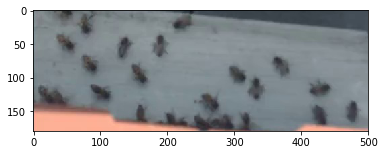

In [3]:
plt.imshow(frames[0])

If needed, we can also convert all frames into grayscale.

In [ ]:
# gray_frames=[]
# for frame in frames:
#     gray_frame=frame.convert('L')
#     gray_frames.append(gray_frame)

### 1. Foreground separation and shape contour extraction

#### ~ preparing bounding boxes ~

#### a) Foreground/background separation

##### I. From article - left just to show approach from article

In [ ]:
# N=10 # parameter - number of image frames to background training. On this N frames there is no object undertaking significant movements in the scene

In [ ]:
# # training stage - MACHINE LEARNING - add ?????
# def get_intensities(frames, N): #iterative formula to compute intensity mean and variance for each pixel
#     shape=frames[0].size
#     for i in range(shape[0]):
#         for j in range(shape[1]):
#             mean[0][i][j]=frames[0][i][j]
#             variance[0][i][j]=0
#     for f in range(1,N):
#         for i in range(shape[0]):
#             for j in range(shape[1]):
#                 mean[f][i][j]=mean[f-1][i][j]+(frames[f][i][j]-mean[f-1][i][j])/f
#                 variance[f][i][j]=(f-2)*(variance[f-1][i][j])/(f-1)+(frames[f][i][j]-mean[f-1][i][j])**2/f
#     return mean, variance

In [ ]:
# # It is preferable that the system can adapt to the illumination change automatically
# # We periodically update the background statistics for pixels outside the bounding boxes (those are background pixels)
# def update_intensities(blocks,frame): # # Is proceeded after getting intensities
#     shape=frame.size
#     for index,block in blocks.enumerated():
#         if block==0: # It is not part of any box
#             for i in range(8*index[0],min(shape[0]-8*index[0], 8*index[0]+8)):
#                 for j in range(8*index[1],min(shape[1]-8*index[1], 8*index[1]+8)):
#                     mean[f][i][j]=mean[f-1][i][j]+(frames[f][i][j]-mean[f][i][j])/N
#                     variance[f][i][j]=variance[f-1][i][j]+(frames[f][i][j]**2-mean[f][i][j]**2)/(N-1)-N*(mean[f][i][j]**2-mean[f-1][i][j]**2)/(N-1)-variance[f][i][j]/N 

In [ ]:
# def get_foreground_pixels(frame,thresh, mean, variance): #we obtain foreground pixels by comparing them to the computed values of mean and variance
#     for i in range(frame.size[0]):
#         for j in range(frame.size[1]):
#             if abs(frame[i][j]-mean[i][j])>thresh*sqrt(variance[i][j]):
#                 foreground[i][j]=1
#             else:
#                 foreground[i][j]=0
#     return foreground          

In [ ]:
# def eliminate_singlepixel_noise(foreground):
#     one iteration of erosion
#     return support_map

##### II. Using algorithm for two-connected components

Two-connected components algorithm not only shows connected components but with all additional option gives us more separated objects.

In [4]:
work_map=[]
for i in range(5):
    work_map.append(two_cc.two_connected_components(frames[i],channel="red",thresh=86))

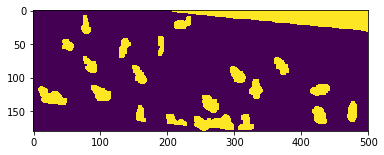

In [5]:
plt.imshow(work_map[0])

Let's note small changes in the two-connected components algorithm available on github:

In [ ]:
# def get_result_array(channel, two_connected_components):    
#     result=np.zeros((channel.shape[0], channel.shape[1]))
#     for comp in two_connected_components:
#         for node in comp:
#             result[node[0],node[1]]=1    
#     return result

# def two_connected_components(img, channel = "all", fill_in = True, thresh = None):
#     image_arr = preparing_image(img, img.size)    
#     binary = converting_to_binary(image_arr, channel, fill_in, thresh)
#     comps_smaller = get_components(binary)
#     return get_result_array(image_arr,comps_smaller)

##### b) Blocks construction

In [6]:
def construct_blocks(support_map): #our support map is divided into 8x8 blocks
    sms=support_map.shape
    width=math.ceil(sms[0]/8)
    height=math.ceil(sms[1]/8)
    blocks=np.zeros( (width, height) )
    for i in range(width):
        for j in range(height):
            # now for each box let's check if it contains more than 15 foreground pixels
            fore_pixels=0
            for k in range(min(8,sms[0]-8*i)): # on the border we can have less than 8 pixels in width/height
                for l in range(min(8,sms[1]-8*j)):
                    if support_map[8*i+k][8*j+l]==1:
                        fore_pixels+=1
            if fore_pixels>15:
                blocks[i][j]=1
    return blocks

In [7]:
blocks=[]
for i in range(5):
    blocks.append(construct_blocks(work_map[i]))

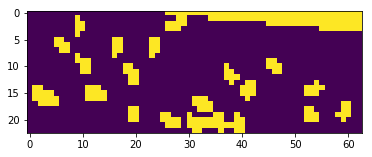

In [8]:
plt.imshow(blocks[0])

We will use algorithm based on DFS to find "connected" boxes. We will assign different integer number to all of them. This approach also gives as possibility to count elements of each components. This will be useful in the future.

In [9]:
# First version:
nums=0 

def dfs(array,box,i,j,index,nums):
    nums+=1
    if i-1 > 0 and array[i-1][j]==1.0 and box[i-1][j]==0.0:
            box[i-1][j]=index
            nums=dfs(array,box,i-1,j,index,nums)
    if j-1 > 0 and array[i][j-1]==1.0 and box[i][j-1]==0.0:
            box[i][j-1]=index
            nums=dfs(array,box,i,j-1,index,nums)
    if i+1 < array.shape[0] and array[i+1][j]==1.0 and box[i+1][j]==0.0:
            box[i+1][j]=index
            nums=dfs(array,box,i+1,j,index,nums)
    if j+1 < array.shape[1] and array[i][j+1]==1.0 and box[i][j+1]==0.0:
            box[i][j+1]=index
            nums=dfs(array,box,i,j+1,index,nums)
    return nums
            
def connected_blocks(array):
    counts=dict()
    nums=0
    index=1
    box=np.zeros(array.shape)
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            if array[i][j]==1.0 and box[i][j]==0.0:
                box[i][j]=index
                nums=dfs(array,box,i,j,index,nums)

                counts[index]=nums
                index+=1
                nums=0
    return box,counts

In [10]:
boxes=[]
count_boxes=[]
for i in range(5):
    array, counts = connected_blocks(blocks[i])
    boxes.append(array)
    count_boxes.append(counts)

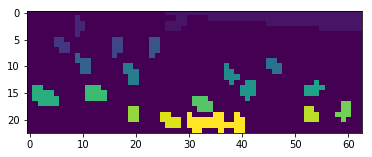

In [11]:
plt.imshow(boxes[0])

In [ ]:
# # Second version:

# # https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.ndimage.measurements.label.html
# joined_blocks=[]

# for i in range(5):
#     joined_block, num_boxes = label(blocks[i])
#     joined_blocks.append(joined_block)

We will eliminate bounding boxes which consits of less than 5 blocks since we don't want to track really small objects.

In [ ]:
# def eliminate_small_boxes(boxes): 
#     #Max=np.amax(array)
#     for k in range(5):
#         unique, counts = np.unique(boxes[k], return_counts=True)
#         small=[]
#         for key, value in dict(zip(unique, counts)):
#             if value<5:
#                 small+=key
#         for i in range(array.shape[0]):
#             for j in range(array.shape[1]):
#                 if boxes[k][i][j] in small:
#                     boxes[k][i][j]=0   
#     return boxes

In [12]:
def eliminate_small_boxes(boxes, counts): 
    small=[]
    for i in range (1, len(counts)+1):
        if counts[i]<5:
            small.append(i)
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            if boxes[i][j] in small:
                boxes[i][j]=0   
    return boxes

In [13]:
reduced_boxes=[]
#reduced_joined_blocks=[]
for i in range(5):
    reduced_boxes.append(eliminate_small_boxes(boxes[i],count_boxes[i]))
    #reduced_joined_blocks.append(eliminate_small_boxes(joined_blocks))

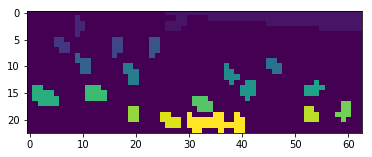

In [14]:
plt.imshow(reduced_boxes[0])

#### 3. Visualization of bounding boxes

In [15]:
def see_boxes(frame,boxes):
    frame_array = np.array(frame, dtype='int16')
    shape=frame.size
    for index,block in np.ndenumerate(boxes):
        if block > 0: 
            for i in range(8*index[0], min(shape[1], 8*index[0]+8)):
                for j in range(8*index[1], min(shape[0], 8*index[1]+8)):
                    frame_array[i][j]=[232,179,56]
    return frame_array

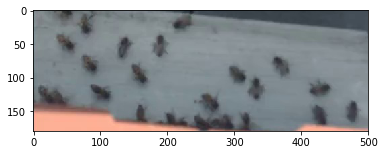

In [16]:
plt.imshow(frames[0])

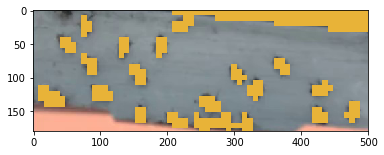

In [17]:
img2=see_boxes(frames[0],reduced_boxes[0])
plt.imshow(img2)

TODO: Only borders should be visible.